# D. Modelisation - Etude de cas UESTA211

In [33]:
from scipy import stats, integrate
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib.colors
import seaborn as sns

from sklearn import model_selection

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors, metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [34]:
#sns.set(color_codes=True)
%matplotlib inline
plt.rc("font", size=10)
#sns.set(style="white")
#sns.set(style="whitegrid", color_codes=True)

np.random.seed(1)

In [35]:
data = pd.read_csv("../DATA/PREPADATA/data_model_q.csv",sep =';', header = 0 )

In [36]:
#Pour l'ACP
data2 = pd.read_csv("../DATA/D_analyse_transformation_avant_acp.csv",sep =';', header = 0 )
# Selection de variables actives non corrélées: (etiquette : target) deltaDistance,  power, lng , messageId

d_modelisation = data[["target", "deltaDistance","lng","power","messageId"]]

d_modelisation.to_csv('../DATA/target_y_best_X.csv', sep = ';',index = False)

X = d_modelisation[["deltaDistance","lng","power","messageId"]]
y = d_modelisation["target"]

In [37]:
df_corr = d_modelisation.corr(method='spearman')
df_corr

,target,deltaDistance,lng,power,messageId
target,1.000000,0.570628,0.013242,0.268091,-0.471623
deltaDistance,0.570628,1.000000,-0.070117,0.327717,-0.530888
lng,0.013242,-0.070117,1.000000,-0.374819,0.008253
power,0.268091,0.327717,-0.374819,1.000000,-0.410192
messageId,-0.471623,-0.530888,0.008253,-0.410192,1.000000


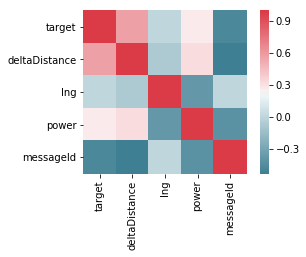

In [38]:
f, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [39]:
data.columns

Index(['distance', 'direction', 'altitude', 'satellites', 'delaiTransmission',
       'delaiServeur', 'delaiBalise', 'deltaDistance', 'volt', 'jourBalise',
       'jourServeur', 'rangDateGPS', 'idBalise', 'messageId', 'vitesse',
       'power', 'lng', 'lat', 'satisfaction', 'target'],
      dtype='object')

In [40]:
# L'analyse epxloratoire montre que la variable la plus influente est le deltaDistance 

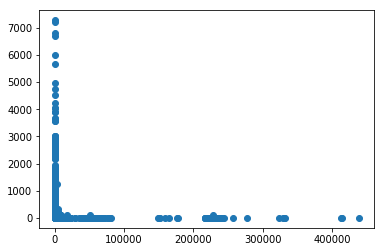

In [41]:
plt.scatter(data.delaiBalise,data.deltaDistance)

plt.show()

# Normalisation des données avant échantillonnage

In [42]:
#standardisation des données train et test
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X_std = std_scale.transform(X)


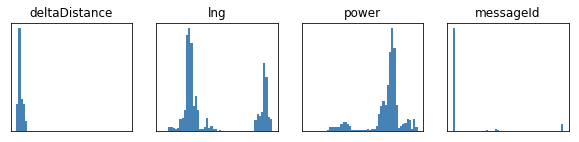

In [43]:
#visualisation des variables avec même ordre de grandeur
fig = plt.figure(figsize=(10, 2))
for feat_idx in range(X_std.shape[1]):    
    ax = fig.add_subplot(1,4, (feat_idx+1))
    h = ax.hist(X_std[:, feat_idx], bins=50, color='steelblue',
    normed=True, edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=12)
    plt.xticks([]), plt.yticks([])

In [44]:
X.shape , y.shape

((161789, 4), (161789,))

In [45]:
# Retraitement des données pour ACP
d_modelisation = data2[["target","vitesse", "deltaDistance","zone","power","messageId","idBalise"]]
X_ACP = d_modelisation[["vitesse", "deltaDistance","zone","power","messageId","idBalise"]]
X_ACP.power = np.where(X_ACP.power<13, 0, 1)
X_ACP.messageId = np.where((X_ACP.messageId!=2)&(X_ACP.messageId!=500) , 999, X_ACP.messageId)
X_ACP = pd.get_dummies(X_ACP, columns =['power','messageId','idBalise','zone'])


/home/user/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [46]:
X_ACP.shape

(161789, 71)

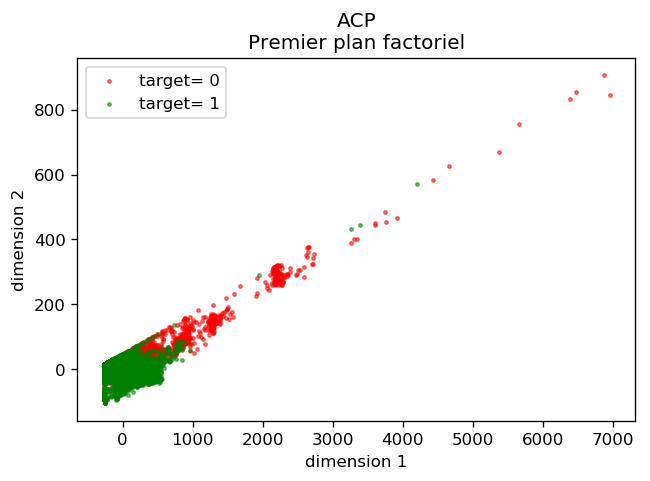

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(X_ACP)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca, y, random_state=0)

plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='target= 0', s=4, color='red')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='target= 1', s=4, color='green')
plt.legend()
plt.title("ACP\nPremier plan factoriel")
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
#plt.gca().set_aspect('equal')
plt.show()

In [48]:
# verification des echantillons
X_train_pca.shape , X_test_pca.shape ,y_train_pca.shape , y.shape

((121341, 2), (40448, 2), (121341,), (161789,))

# Echantillonage identique pour toutes les méthodes

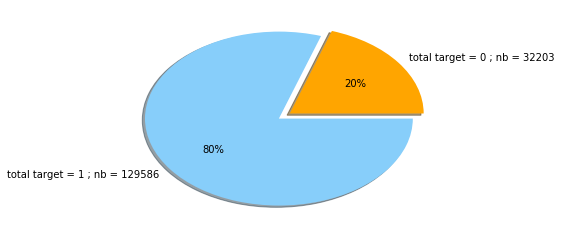

In [49]:
#representation des classes
s=y.value_counts()
strlabel0='total target = 0 ; nb = '+str(s[0])
strlabel1='total target = 1 ; nb = '+str(s[1])

labels=[strlabel0,strlabel1]
sizes =[s[0],s[1]]
colors =['orange','lightskyblue']
explode =(0.1,0)
plt.pie(sizes,explode=explode,labels=labels, colors=colors, autopct='%1.0f%%', shadow=True)
plt.show()

In [50]:
#je veux un echantillon qui n'est pas utilisé pour créer ou valider le model
#on fixe la graine de l'echantillonage pour reproduire random_state=1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

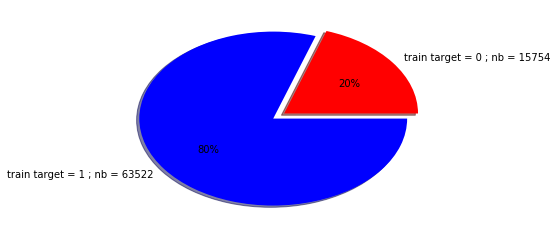

In [51]:
#representation des classes 
s=y_train.value_counts()
strlabel0='train target = 0 ; nb = '+str(s[0])
strlabel1='train target = 1 ; nb = '+str(s[1])

labels=[strlabel0,strlabel1]
sizes =[s[0],s[1]]
colors =['red','blue']
explode =(0.1,0)
plt.pie(sizes,explode=explode,labels=labels, colors=colors, autopct='%1.0f%%', shadow=True)
plt.show()

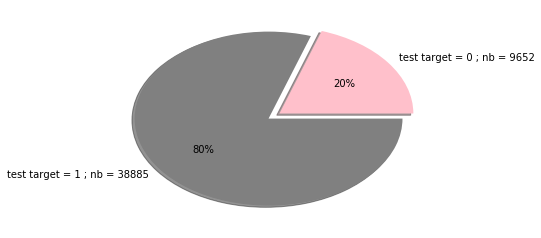

In [52]:
#representation des classes 
s=y_test.value_counts()
strlabel0='test target = 0 ; nb = '+str(s[0])
strlabel1='test target = 1 ; nb = '+str(s[1])

labels=[strlabel0,strlabel1]
sizes =[s[0],s[1]]
colors =['pink','grey']
explode =(0.1,0)
plt.pie(sizes,explode=explode,labels=labels, colors=colors, autopct='%1.0f%%', shadow=True)
plt.show()

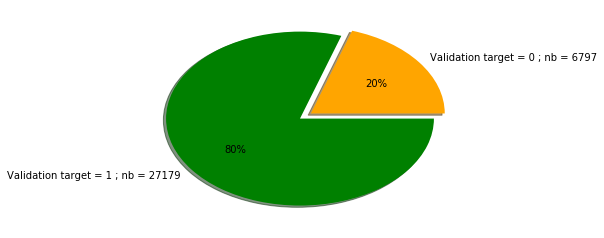

In [53]:
#representation des classes
s=y_val.value_counts()
strlabel0='Validation target = 0 ; nb = '+str(s[0])
strlabel1='Validation target = 1 ; nb = '+str(s[1])

labels=[strlabel0,strlabel1]
sizes =[s[0],s[1]]
colors =['orange','green']
explode =(0.1,0)
plt.pie(sizes,explode=explode,labels=labels, colors=colors, autopct='%1.0f%%', shadow=True)
plt.show()

In [54]:
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Regression Logistique (classifier)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'C': 0.01}
_Regression logistique_ Résultats de la validation croisée :
	accuracy = 0.855 (+/-0.003) for {'C': 0.01}
	accuracy = 0.854 (+/-0.002) for {'C': 0.05}
	accuracy = 0.854 (+/-0.003) for {'C': 0.1}
Précision du classifieur Regression Logistique sur le jeu de test : 0.852
col_0      0      1
target             
0       3996   5656
1       1550  37335


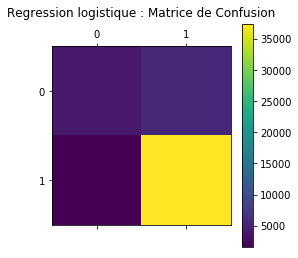

Aire sous la courbe ROC (AUC) : 0.909
Sensibilité : 0.95
1-Spécificité : 0.58
Seuil : 0.76

 Estimation de l'erreur de prévision : 0.15


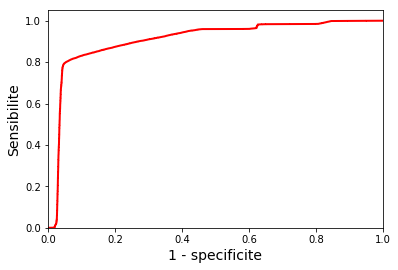

In [55]:
# Fixer les valeurs des hyperparamètres à tester
param=[{"C":[0.01,0.05,0.1]}]
# Créer un classifieur (Regression logistique)
classifier = model_selection.GridSearchCV(LogisticRegression(penalty="l1"),param,cv=5,scoring=score,n_jobs=-1)

# optimisation sur jeu d'entrainement
classifier.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",classifier.best_params_)

# Afficher les performances correspondantes
print ("_Regression logistique_ Résultats de la validation croisée :")
for mean, std, params in zip(classifier.cv_results_['mean_test_score'], # score moyen
    classifier.cv_results_['std_test_score'], # écart-type du score
    classifier.cv_results_['params'] # valeur de l'hyperparamètre
    ):
    print ("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
    mean, # score moyen
    std * 2, # barre d'erreur
    params) # hyperparamètre
)

# regardons la performance sur le jeu de test. 
#Prévision de l'échantillon test et matrice de confusion.
#GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement,
y_pred = classifier.predict(X_test)
#score
print('Précision du classifieur Regression Logistique sur le jeu de test : {:.3f}'.format(classifier.score(X_test, y_test)))

# matrice de confusion
table=pd.crosstab(y_test,y_pred)
print(table)
plt.matshow(table)
plt.title("Regression logistique : Matrice de Confusion\n")
plt.colorbar()
plt.show()

#Courbe ROC de la regression logistique
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

#Aire sous la courbe ROC du regression logistique
print ("Aire sous la courbe ROC (AUC) : %.3f" % metrics.auc(fpr, tpr))

#Regression logistique indices sur-apprentissage
idx = np.min(np.where(tpr > 0.95)) # indice du premier seuil pour lequel
                                   # la sensibilité est supérieure à 0.95
print ("Sensibilité : %.2f" % tpr[idx])
print ("1-Spécificité : %.2f" % (1-fpr[idx]))
print ("Seuil : %.2f" % thr[idx])

# Estimation de l'erreur de prévision
err=1-classifier.score(X_test,y_test)
print ("\n Estimation de l'erreur de prévision : %.2f" % err)


> ###  KNN (clf)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'n_neighbors': 15}
_KNN_ Résultats de la validation croisée :
	accuracy = 0.889 (+/-0.003) for {'n_neighbors': 3}
	accuracy = 0.892 (+/-0.003) for {'n_neighbors': 5}
	accuracy = 0.894 (+/-0.004) for {'n_neighbors': 9}
	accuracy = 0.893 (+/-0.003) for {'n_neighbors': 13}
	accuracy = 0.894 (+/-0.004) for {'n_neighbors': 15}
Précision du classifieur KNN sur le jeu de test : 0.894
col_0      0      1
target             
0       6359   3293
1       1876  37009


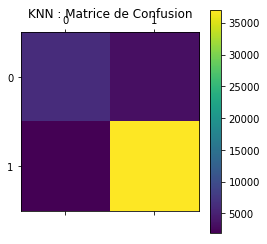

Aire sous la courbe ROC (AUC) : 0.947
Sensibilité : 0.95
1-Spécificité : 0.66
Seuil : 0.53

 Estimation de l'erreur de prévision : 0.11


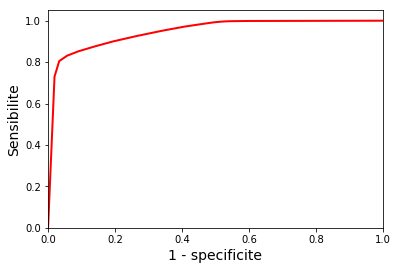

In [56]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 9,13, 15]}

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), # un classifieur kNN
param_grid, # hyperparamètres à tester
cv=5, # nombre de folds de validation croisée
scoring=score # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print ("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",clf.best_params_)
# Afficher les performances correspondantes
print ("_KNN_ Résultats de la validation croisée :")
for mean, std, params in zip(clf.cv_results_['mean_test_score'], # score moyen
    clf.cv_results_['std_test_score'], # écart-type du score
    clf.cv_results_['params'] # valeur de l'hyperparamètre
    ):
    print ("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
    mean, # score moyen
    std * 2, # barre d'erreur
    params) # hyperparamètre
)
#print("\n temps CPU : ")
#print(time.clock()-tps_debut)
#print("\n temps horloge : ")
#print(time.time()-time_debut)

# regardons la performance sur le jeu de test. 
#Prévision de l'échantillon test et matrice de confusion.
#GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement,
y_pred = clf.predict(X_test)
#print ("\nPrécision sur le jeu de test : %0.3f" % metrics.accuracy_score(y_test, y_pred))
print('Précision du classifieur KNN sur le jeu de test : {:.3f}'.format(clf.score(X_test, y_test)))

# matrice de confusion
table=pd.crosstab(y_test,y_pred)
print(table)
plt.matshow(table)
plt.title("KNN : Matrice de Confusion")
plt.colorbar()
plt.show()

#Courbe ROC du KNN
y_pred_proba = clf.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

#Aire sous la courbe ROC du KNN
print ("Aire sous la courbe ROC (AUC) : %.3f" % metrics.auc(fpr, tpr))

#KNN indices sur-apprentissage
idx = np.min(np.where(tpr > 0.95)) # indice du premier seuil pour lequel
                                   # la sensibilité est supérieure à 0.95
print ("Sensibilité : %.2f" % tpr[idx])
print ("1-Spécificité : %.2f" % (1-fpr[idx]))
print ("Seuil : %.2f" % thr[idx])

# Estimation de l'erreur de prévision
err=1-clf.score(X_test,y_test)
print ("\n Estimation de l'erreur de prévision : %.2f" % err)


> ###  Arbre de décision

Meilleur profondeur de l'arbre de décision : 
{'max_depth': 8}
Score du classifieur ARBRE sur le jeu de test : 0.899
_Abre de décision _ Résultats de la validation croisée :
	accuracy = 0.898 (+/-0.004) for {'max_depth': 5}
	accuracy = 0.898 (+/-0.004) for {'max_depth': 6}
	accuracy = 0.899 (+/-0.003) for {'max_depth': 7}
	accuracy = 0.899 (+/-0.004) for {'max_depth': 8}
	accuracy = 0.899 (+/-0.004) for {'max_depth': 9}
	accuracy = 0.882 (+/-0.004) for {'max_features': 1}
	accuracy = 0.885 (+/-0.003) for {'max_features': 2}
	accuracy = 0.886 (+/-0.005) for {'max_features': 3}
	accuracy = 0.885 (+/-0.007) for {'max_features': 4}
Précision du classifieur Arbre de decision sur le jeu de test : 0.894
col_0      0      1
target             
0       6463   3189
1       1692  37193


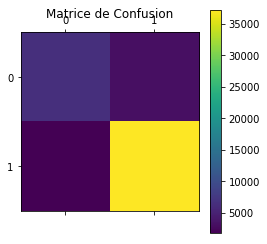

Aire sous la courbe ROC (AUC) : 0.909
Sensibilité : 0.95
1-Spécificité : 0.58
Seuil : 0.76

 Estimation de l'erreur de prévision : 0.10


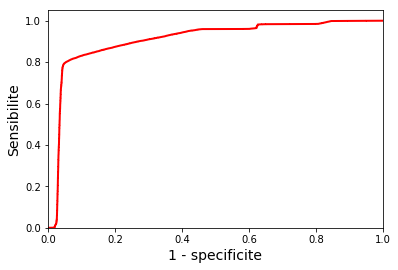

In [57]:
###########################
###  Arbre de decision  ###   
###########################
# Fixer les valeurs des hyperparamètres à tester
param=[{"max_depth":list(range(5,10))},{"max_features":[1,2,3,4]}]

#Creation de l'arbre de decision par validation croisée
data_tree= model_selection.GridSearchCV(DecisionTreeClassifier(),
                                        param_grid=param,
                                        cv=5,
                                        scoring=score,
                                        n_jobs=-1)

# Optimiser ce classifieur sur le jeu d'entraînement
#data_opt=data_tree.fit(X_train, y_train)
data_tree.fit(X_train, y_train)


# paramètre optimal
print ("Meilleur profondeur de l'arbre de décision : ")
print(data_tree.best_params_)
print('Score du classifieur ARBRE sur le jeu de test : {:.3f}'.format(data_tree.score(X_test, y_test)))

# Afficher les performances correspondantes
print ("_Abre de décision _ Résultats de la validation croisée :")
for mean, std, params in zip(data_tree.cv_results_['mean_test_score'], # score moyen
    data_tree.cv_results_['std_test_score'], # écart-type du score
    data_tree.cv_results_['params'] # valeur de l'hyperparamètre
    ):
    print ("\t%s = %0.3f (+/-%0.03f) for %r" % (score, # critère utilisé
    mean, # score moyen
    std * 2, # barre d'erreur
    params) # hyperparamètre
)

#Estimation de l'arbre "optimal". 
data_tree.fit(X_train, y_train)

#Prévision de l'échantillon test et matrice de confusion.
y_pred = data_tree.predict(X_test)
print('Précision du classifieur Arbre de decision sur le jeu de test : {:.3f}'.format(clf.score(X_test, y_test)))

# matrice de confusion
table=pd.crosstab(y_test,y_pred)
print(table)
plt.matshow(table)
plt.title("Matrice de Confusion")
plt.colorbar()
plt.show()

#Courbe ROC de l'arbre
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='red', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilite', fontsize=14)

#Aire sous la courbe ROC de l'arbre
print ("Aire sous la courbe ROC (AUC) : %.3f" % metrics.auc(fpr, tpr))

#Arbre indices sur-apprentissage
idx = np.min(np.where(tpr > 0.95)) # indice du premier seuil pour lequel
                                   # la sensibilité est supérieure à 0.95
print ("Sensibilité : %.2f" % tpr[idx])
print ("1-Spécificité : %.2f" % (1-fpr[idx]))
print ("Seuil : %.2f" % thr[idx])

# Estimation de l'erreur de prévision
err=1-data_tree.score(X_test,y_test)
print ("\n Estimation de l'erreur de prévision : %.2f" % err)


In [81]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

#using iris data set
#df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data",
names = ['deltaDistance', 'lng', 'power', 'messageId']

models = []
models.append(("LOGIT", classifier ))
models.append(("KNN", clf ))
models.append(("DTREE", data_tree) )

model_names = []
means = []
stds = []

#shuffle our data and we use 121 out of 150 as training data
data_array = X_val.values
np.random.shuffle(data_array)
X_learning = X_val#data_array[:121][:,0:4]
Y_learning = y_val#data_array[:121][:,4]

#split our data in 5 folds
kfold = model_selection.KFold(n_splits=5)

def showSplitting(X_learning):
    for train_index, test_index in kfold.split(X_learning):
        print("Train Index:")
        print(train_index)
        print("Test Index:")
        print(test_index)  

#uncomment following to x how do samples split        
#showSplitting(X_learning)        

for name, model in models:
    val_score=model.score(X_val, y_val) 
    cv_results = model_selection.cross_val_score(model, X_learning, Y_learning, scoring='accuracy', cv=kfold )
    print("\n"+name)
    #print(model)      
    model_names.append(name)
    print("Score sur echantillon de validation : %.3f" % (val_score))
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    [fpr, tpr, thr] = metrics.roc_curve(y_val, y_pred_proba)
    print ("Aire sous la courbe ROC (AUC) : %.3f" % metrics.auc(fpr, tpr))
    #Arbre indices sur-apprentissage
    idx = np.min(np.where(tpr > 0.95)) # indice du premier seuil pour lequel
    # la sensibilité est supérieure à 0.95
    print ("Sensibilité : %.2f" % tpr[idx])
    print ("1-Spécificité : %.2f" % (1-fpr[idx]))
    print ("Seuil : %.2f" % thr[idx])
    print("Mean: " + str(cv_results.mean()))
    print("Standard Deviation: " + str(cv_results.std()))
    means.append(cv_results.mean())
    stds.append(cv_results.std())


LOGIT
Score sur echantillon de validation : 0.851
Aire sous la courbe ROC (AUC) : 0.915
Sensibilité : 0.95
1-Spécificité : 0.57
Seuil : 0.76
Mean: 0.852189644517
Standard Deviation: 0.00435883199146

KNN
Score sur echantillon de validation : 0.895
Aire sous la courbe ROC (AUC) : 0.949
Sensibilité : 0.95
1-Spécificité : 0.67
Seuil : 0.53
Mean: 0.893601412942
Standard Deviation: 0.00388344399216

DTREE
Score sur echantillon de validation : 0.902
Aire sous la courbe ROC (AUC) : 0.954
Sensibilité : 0.96
1-Spécificité : 0.68
Seuil : 0.51
Mean: 0.897780757499
Standard Deviation: 0.00398306132141


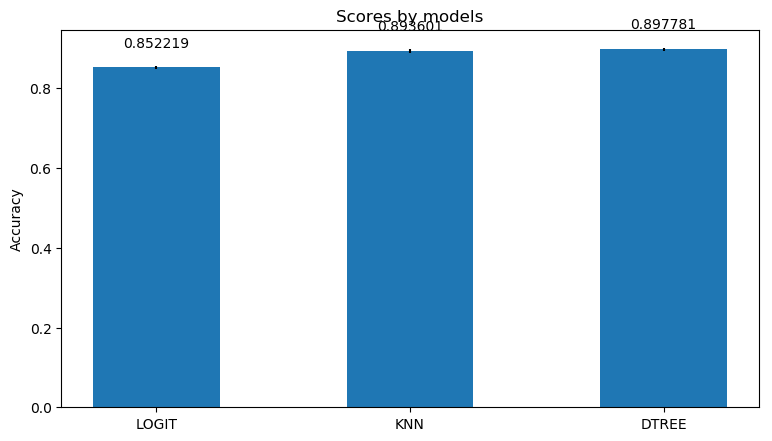

In [78]:
#bigger size in inches (width, height) & resolution(DPI)        
plt.figure(figsize=(9, 5), dpi=100)        
        
#plot the graphs with bar chart
x_loc = np.arange(len(models)) # the x locations for the groups
width = 0.5   # bar width

models_graph = plt.bar(x_loc, means, width, yerr=stds)
plt.ylabel('Accuracy')
plt.title('Scores by models')
plt.xticks(x_loc, model_names) # models name on x-axis

#add valve on the top of every bar
def addLabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % height, ha='center', 
                 va='bottom')

addLabel(models_graph)

plt.show()


LoR
Results: [ 0.85697469  0.84930096  0.84812362  0.85562914  0.84827079]
Mean: 0.851659838861
Standard Deviation: 0.00383556605465

LDA
Results: [ 0.85579753  0.85253863  0.85033113  0.85901398  0.85033113]
Mean: 0.853602478366
Standard Deviation: 0.00336564607114

QDA
Results: [ 0.84932313  0.84841795  0.84282561  0.85459897  0.84797645]
Mean: 0.84862842316
Standard Deviation: 0.00374892206819

SVC
Results: [ 0.89287816  0.89080206  0.88977189  0.89595291  0.89580574]
Mean: 0.893042152225
Standard Deviation: 0.00252386280174

LSVC
Results: [ 0.86080047  0.15202355  0.81883738  0.19852833  0.87181751]
Mean: 0.58040144811
Standard Deviation: 0.331582066337

SGD
Results: [ 0.81695115  0.866078    0.86269316  0.78675497  0.85607064]
Mean: 0.837709582012
Standard Deviation: 0.0309624285694


/home/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/user/anaconda3


KNN
Results: [ 0.89052384  0.88609272  0.88447388  0.89713024  0.8946284 ]
Mean: 0.89056981534
Standard Deviation: 0.00483152848938

GNB
Results: [ 0.83343143  0.83414275  0.83119941  0.83870493  0.83296542]
Mean: 0.83408878789
Standard Deviation: 0.00250416700402

DT
Results: [ 0.87992937  0.8785872   0.87932303  0.88874172  0.88241354]
Mean: 0.88179897191
Standard Deviation: 0.003701909295

RF
Results: [ 0.88758093  0.88933039  0.88682855  0.8928624   0.89256806]
Mean: 0.889834066786
Standard Deviation: 0.00249034071577


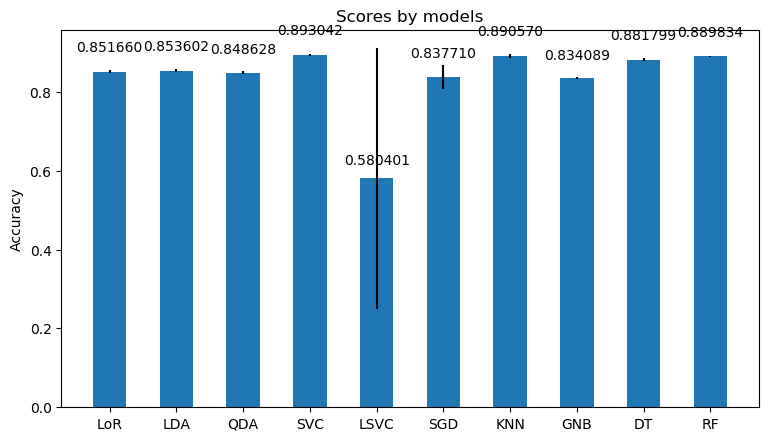

In [80]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#using iris data set
#df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data",
names = ['deltaDistance', 'lng', 'power', 'messageId']

models = []
models.append(("LoR", LogisticRegression()) )
models.append(("LDA", LinearDiscriminantAnalysis()) )
models.append(("QDA", QuadraticDiscriminantAnalysis()) )
models.append(("SVC", SVC()) )
models.append(("LSVC", LinearSVC()) )
models.append(("SGD", SGDClassifier()) )
models.append(("KNN", KNeighborsClassifier()) )
models.append(("GNB", GaussianNB() ))
models.append(("DT", DecisionTreeClassifier()) )
models.append(("RF", RandomForestClassifier()) )

model_names = []
means = []
stds = []

#shuffle our data and we use 121 out of 150 as training data
data_array = X_val.values
np.random.shuffle(data_array)
X_learning = X_val#data_array[:121][:,0:4]
Y_learning = y_val#data_array[:121][:,4]

#split our data in 10 folds
kfold = model_selection.KFold(n_splits=5)

def showSplitting(X_learning):
    for train_index, test_index in kfold.split(X_learning):
        print("Train Index:")
        print(train_index)
        print("Test Index:")
        print(test_index)  

#uncomment following to x how do samples split        
#showSplitting(X_learning)        

for name, model in models:
     #cross validation among models, score based on accuracy
     cv_results = model_selection.cross_val_score(model, X_learning, Y_learning, scoring='accuracy', cv=kfold )
     print("\n"+name)
     model_names.append(name)
     print("Results: "+str(cv_results))
     print("Mean: " + str(cv_results.mean()))
     print("Standard Deviation: " + str(cv_results.std()))
     means.append(cv_results.mean())
     stds.append(cv_results.std())

#bigger size in inches (width, height) & resolution(DPI)        
plt.figure(figsize=(9, 5), dpi=100)        
        
#plot the graphs with bar chart
x_loc = np.arange(len(models)) # the x locations for the groups
width = 0.5   # bar width

models_graph = plt.bar(x_loc, means, width, yerr=stds)
plt.ylabel('Accuracy')
plt.title('Scores by models')
plt.xticks(x_loc, model_names) # models name on x-axis

#add valve on the top of every bar
def addLabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % height, ha='center', 
                 va='bottom')

addLabel(models_graph)

plt.show()


In [84]:
X_val.to_csv('../DATA/X_val.csv', sep = ';',index = False)
y_val.to_csv('../DATA/y_val.csv', sep = ';',index = False)
X_train.to_csv('../DATA/X_train.csv', sep = ';',index = False)
y_train.to_csv('../DATA/y_train.csv', sep = ';',index = False)
X_test.to_csv('../DATA/X_test.csv', sep = ';',index = False)
y_test.to_csv('../DATA/y_test.csv', sep = ';',index = False)